In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Terraform,54.123498,27.061749,27.696486,2
OAuth 2.0 RFC6749,145.953421,18.244178,42.277720,8
Azure Functions + PP365,188.689737,37.737947,57.365736,5
Django,234.323686,5.858092,17.840167,40
Node.js and Vite,249.264512,6.079622,17.055179,41
pfSense,473.553950,39.462829,129.141212,12
CCH Tax Forms Project,553.236023,26.344573,96.103655,21
Accounting,612.376114,36.022124,94.597060,17
Python + Oauth2.0,795.395678,34.582421,106.978471,23
FSLogix,877.430312,73.119193,160.809904,12


# Histogram

sum of ages: ~43252.05


<Axes: >

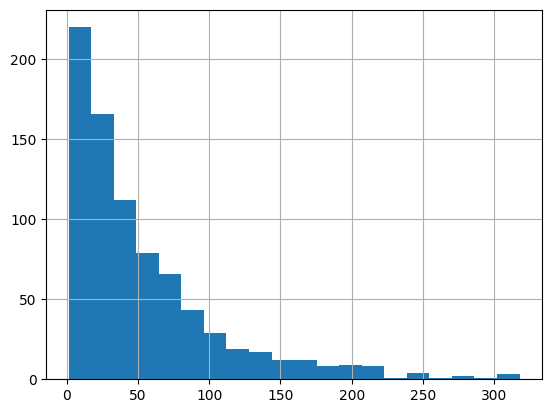

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~43252.05


<Axes: >

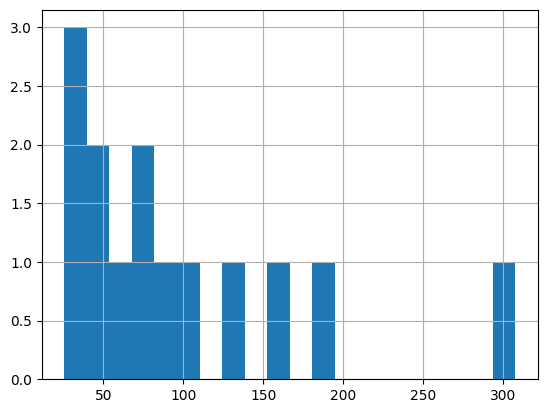

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 812
Total card age: 43252.05


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
55,Asynchronous Python,Race Condition\nA race condition occurs when m...,56259820681abe2cac07ac869cd50777,317.821897,66.598714,-317.821897,1465.171717,0.361166,22,0,0,-317.821897
334,Asynchronous Python,asyncio.Semaphore\nA concurrency control mecha...,88d632e7c2c0e3631973b25e8c248a0a,118.241200,66.598714,-317.821897,1465.171717,0.361166,22,1,0,-118.241200
609,Asynchronous Python,Task\nA wrapper around a coroutine in Python’s...,97ae921b03b2b2adab9ff0c7e1081feb,103.000410,66.598714,-317.821897,1465.171717,0.361166,22,2,0,-103.000410
56,Asynchronous Python,Cooperative Multitasking\nThe async model in P...,71ac5b970658e9c888a90c4478508455,96.929366,66.598714,-317.821897,1465.171717,0.361166,22,3,0,-96.929366
335,Asynchronous Python,pytest-asyncio\nA Python testing plugin that a...,cc408bf4b0492b651b430a85af948045,95.438032,66.598714,-317.821897,1465.171717,0.361166,22,4,0,-95.438032
84,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,315.300422,63.062073,-315.300422,1513.489757,0.843025,24,0,0,-315.300422
362,TSQL,Column and Table Aliasing:\n\nUse the AS keywo...,b2d566df6211f9f8dfb6e5a7760dec96,121.223511,63.062073,-315.300422,1513.489757,0.843025,24,1,0,-121.223511
636,TSQL,"Q: Why would you use COALESCE(a, b) in a SELEC...",9599c71bb44aa9c23eca4cb094d34e63,94.511965,63.062073,-315.300422,1513.489757,0.843025,24,2,0,-94.511965
85,TSQL,Q: How do window functions differ from aggrega...,8a0c598806647a8b39c057348c65f578,92.321280,63.062073,-315.300422,1513.489757,0.843025,24,3,0,-92.321280
363,TSQL,Temporary Tables:\n\nCreated with a hash (#) p...,abb2b766275c2aaa389f749f4c957071,90.297571,63.062073,-315.300422,1513.489757,0.843025,24,4,0,-90.297571


## Card Count

In [26]:
# n=3
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(1445.085652116453)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
55,Asynchronous Python,Race Condition\nA race condition occurs when m...,56259820681abe2cac07ac869cd50777,317.821897,66.598714,-317.821897,1465.171717,0.361166,22,0,0,-317.821897
84,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,315.300422,63.062073,-315.300422,1513.489757,0.843025,24,0,0,-315.300422
272,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,307.409189,99.218981,-307.409189,1389.065728,0.849975,14,0,0,-307.409189
128,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,296.163948,61.078619,-296.163948,2992.852315,0.103085,49,0,0,-296.163948
18,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,283.997206,84.969649,-283.997206,3568.725275,0.452946,42,0,0,-283.997206
43,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,282.259927,71.942101,-282.259927,2589.915640,0.559755,36,0,0,-282.259927
8,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,258.961554,85.062043,-258.961554,2381.737217,0.120478,28,0,0,-258.961554
289,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,252.668495,85.062043,-258.961554,2381.737217,0.120478,28,1,0,-252.668495
279,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,251.052446,87.838433,-251.052446,2459.476114,0.196069,28,0,0,-251.052446
156,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,249.677473,51.853374,-249.677473,3681.589568,0.784849,71,0,0,-249.677473


In [30]:
existing_cards['age'].mean()

np.float64(53.26607731173848)